### Imports

In [1]:
import h5py
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path

In [2]:
BASEDIR = Path("")

fn = BASEDIR / "train_eval.hdf5"

### Pre Evaluation

Iterate over the different Groups and summarize them to get an idea of which to use to analyze

In [4]:
objectWithMask = 0
objectWithPost_fire = 0
objectWithPre_fire = 0

objectsSummary = []
currentObject = {}

def listObject(obj, indent=0):
    global objectWithMask
    global objectWithPost_fire
    global objectWithPre_fire
    global objectsSummary
    global currentObject

    
    
    for name, thing in obj.items():
        if indent == 0:
            currentObject = { "name" : "", "mask": False, "pre_fire" : False, "post_fire": False}

        if isinstance(thing, h5py.Group):
            if indent == 0:
                currentObject["name"] = name
            listObject(thing, indent+1)
            
        else:
            if name == "mask":
                currentObject["mask"] = True
                objectWithMask += 1
            elif name == "post_fire":
                currentObject["post_fire"] = True
                objectWithPost_fire += 1
            elif name == "pre_fire":
                currentObject["pre_fire"] = True
                objectWithPre_fire += 1
            else:
                print(name)
    
        if indent == 0:
            objectsSummary.append(currentObject)

    

with h5py.File(fn, "r") as fd:
    listObject(fd)

In [5]:
print("Items with mask: " + str(objectWithMask))
print("Items with pre_fire: " + str(objectWithPre_fire))
print("Items with post_fire: " + str(objectWithPost_fire))
print("Overall Items: " + str(len(objectsSummary)))

Items with mask: 534
Items with pre_fire: 356
Items with post_fire: 534
Overall Items: 534


### Single Case Evaluation

Visualizing some of the images provided

In [6]:
# Function copied from practice
def to_xarray(dataset, pretty_band_names=True):
    """... Ergänzen Sie hier eine guten Docstring ... """
    
    if pretty_band_names:
        BANDS = ["coastal_aerosol", "blue", "green", "red",
                 "veg_red_1", "veg_red_2", "veg_red_3", "nir", 
                 "veg_red_4", "water_vapour", "swir_1", "swir_2"]
    else:
        BANDS = ["1", "2", "3", "4", "5", "6", "7", "8", "8a", "9", "11", "12"]
        
    post = dataset["post_fire"][...].astype("float32") / 10000.0
    
    # Da `pre_fire` manchmal fehlt ersetzen wir es durch 0 Werte was
    # eh der Platzhalter für einen fehlenden Messwert ist.
    try:
        pre = dataset["pre_fire"][...].astype("float32") / 10000.0
    except KeyError:
        pre = np.zeros_like(post, dtype="float32")
        
    # Da die Maske nur ein "Band" hat können wir die dritte Dimension einfach
    # weglassen. Das erreichen wir in dem wir mit `0` am Ende indizieren.
    mask = dataset["mask"][..., 0]
    
    return {"pre": xr.DataArray(pre, dims=["x", "y", "band"], coords={"x": range(512), "y": range(512), "band": BANDS}),
            "post": xr.DataArray(post, dims=["x", "y", "band"], coords={"x": range(512), "y": range(512), "band": BANDS}),
            "mask": xr.DataArray(mask, dims=["x", "y"], coords={"x": range(512), "y": range(512)}),
            "fold": dataset.attrs["fold"]}

In [9]:
with h5py.File(fn, "r") as fd:
    data = to_xarray(fd["0328d12a-4ad8-4504-8ac5-70089db10b4e_0"])

pre = data["pre"]
post = data["post"]
mask = data["mask"]
diff = data["post"] - data["pre"]

n_bands = len(pre.band)

Looking at pre- and post- image

In [ ]:
# Gamma Korrektur **0.45
fig, ax =  plt.subplots(nrows=2, ncols=1, figsize=(12, 3*12))

ax[0].imshow(pre.sel(band=["red", "green", "blue"]).values**0.45, vmin=0, vmax=1, interpolation="nearest")
ax[1].imshow(post.sel(band=["red", "green", "blue"]).values**0.45, vmin=0, vmax=1, interpolation="nearest")
# ax[1].imshow(deltaMask.sel(band=["red", "green", "blue"]).values**0.45, vmin=0, vmax=1, interpolation="nearest")
for i in range(2):
    ax[i].axis("off")
fig.tight_layout()

Comparing single bands using images

In [ ]:
fig, ax =  plt.subplots(nrows=n_bands, ncols=4, figsize=(4 * 4, 4 * n_bands))

for i, band in enumerate(pre.band):
    ax[i, 0].imshow(diff.sel(band=band).values, cmap='gray', interpolation="nearest")
    ax[i, 0].set_title(band.values)
    ax[i, 1].imshow(pre.sel(band=band).values, cmap='gray', interpolation="nearest")
    ax[i, 1].set_title("pre")
    ax[i, 2].imshow(post.sel(band=band).values, cmap='gray', interpolation="nearest")
    ax[i, 2].set_title("post")
    ax[i, 3].imshow(mask.values, interpolation="nearest")
    ax[i, 3].set_title("mask")
    for j in range(4):
        ax[i, j].axis("off")
fig.tight_layout()

Display each Bands pre to post delta accuracy when compared to mask

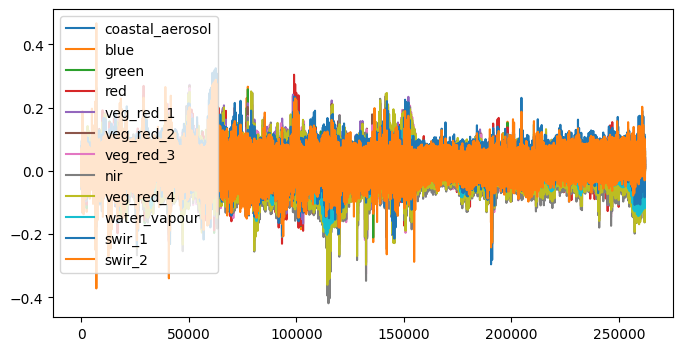

In [53]:
# Calculate the delta between the pre and post-fire images
delta = post - pre

fig, ax = plt.subplots(figsize=(8, 4))
for band in post.band:
    selBand = delta.sel(band=band).values.flatten()
    
    ax.plot(selBand, label=band.values)

plt.legend()
plt.show()




### Broad Analysis